Выполним импорт необходимых библиотек

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms,datasets

Зададим нормализующие преобразования, загрузим набор
данных (MNIST), разобьем данные на подвыборки

In [11]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.0,), (1.0,))])
dataset = datasets.MNIST(root = './data', train=True, transform = transform, download=True)
train_set, val_set = torch.utils.data.random_split(dataset, [50000, 10000])
test_set = datasets.MNIST(root = './data', train=False, transform = transform, download=True)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=1,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=1,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=1,shuffle=True)

Настроим использование графического ускорителя

In [12]:
use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

Создадим класс НС на основе фреймворка torch

In [13]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout(0.25)
    self.dropout2 = nn.Dropout(0.5)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)
  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    output = F.log_softmax(x, dim=1)
    return output

Проверим работоспособность созданного класса НС

In [14]:
model = Net().to(device)

Создадим оптимизатор, функцию потерь и трейнер сети

In [15]:
optimizer = optim.Adam(model.parameters(),lr=0.0001, betas=(0.9, 0.999))
criterion = nn.NLLLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

Определили функцию обучения сети

In [16]:
def fit(model,device,train_loader,val_loader,epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  print("Fitting the model...")
  train_loss,val_loss=[],[]
  for epoch in range(epochs):
    loss_per_epoch,val_loss_per_epoch=0,0
    for phase in ('train','val'):
      for i,data in enumerate(data_loader[phase]):
        input,label  = data[0].to(device),data[1].to(device)
        output = model(input)
        #calculating loss on the output
        loss = criterion(output,label)
        if phase == 'train':
          optimizer.zero_grad()
          #grad calc w.r.t Loss func
          loss.backward()
          #update weights
          optimizer.step()
          loss_per_epoch+=loss.item()
        else:
          val_loss_per_epoch+=loss.item()
    scheduler.step(val_loss_per_epoch/len(val_loader))
    print("Epoch: {} Loss: {} Val_Loss: {}".format(epoch+1,loss_per_epoch/len(train_loader),val_loss_per_epoch/len(val_loader)))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))
  return train_loss,val_loss

Обучим модель

In [17]:
loss,val_loss=fit(model,device,train_loader,val_loader,10)

Fitting the model...
Epoch: 1 Loss: 0.24841752398738037 Val_Loss: 0.12061824470002139
Epoch: 2 Loss: 0.09896987803633864 Val_Loss: 0.08424650834364011
Epoch: 3 Loss: 0.07869950483775712 Val_Loss: 0.08328769305922769
Epoch: 4 Loss: 0.07311822975879405 Val_Loss: 0.10720105448503194
Epoch: 5 Loss: 0.06926371024317246 Val_Loss: 0.0884460765918882
Epoch: 6 Loss: 0.06806250782961033 Val_Loss: 0.11510764005056094
Epoch: 7 Loss: 0.06674116253729839 Val_Loss: 0.10574276480031856
Epoch: 8 Loss: 0.04912241660950879 Val_Loss: 0.0683882074708118
Epoch: 9 Loss: 0.044145967845800285 Val_Loss: 0.0758055572589581
Epoch: 10 Loss: 0.044831771374373657 Val_Loss: 0.07181386937930914


Построим графики потерь при обучении и валидации в зависимости от эпохи

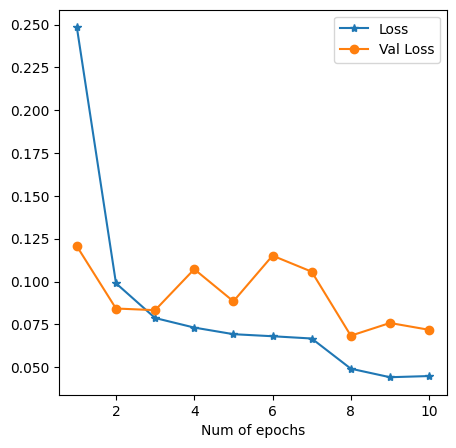

In [18]:
fig = plt.figure(figsize=(5,5))
plt.plot(np.arange(1,11), loss, "*-",label="Loss")
plt.plot(np.arange(1,11), val_loss,"o-",label="Val Loss")
plt.xlabel("Num of epochs")
plt.legend()
plt.show()

Создадим функции атак FGSM, I-FGSM, MI-FGSM

In [19]:
def fgsm_attack(input,epsilon,data_grad):
  pert_out = input + epsilon*data_grad.sign()
  pert_out = torch.clamp(pert_out, 0, 1)
  return pert_out

In [20]:
def ifgsm_attack(input,epsilon,data_grad):
 iter = 10
 alpha = epsilon/iter
 pert_out = input
 for i in range(iter-1):
  pert_out = pert_out + alpha*data_grad.sign()
  pert_out = torch.clamp(pert_out, 0, 1)
  if torch.norm((pert_out-input),p=float('inf')) > epsilon:
    break
 return pert_out

In [21]:
def mifgsm_attack(input,epsilon,data_grad):
  iter=10
  decay_factor=1.0
  pert_out = input
  alpha = epsilon/iter
  g=0
  for i in range(iter-1):
    g = decay_factor*g + data_grad/torch.norm(data_grad,p=1)
    pert_out = pert_out + alpha*torch.sign(g)
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

Создадим функцию проверки

In [22]:
def test(model,device,test_loader,epsilon,attack):
  correct = 0
  adv_examples = []
  for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    data.requires_grad = True
    output = model(data)
    init_pred = output.max(1, keepdim=True)[1]
    if init_pred.item() != target.item():
      continue
    loss = F.nll_loss(output, target)
    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data
    if attack == "fgsm":
      perturbed_data = fgsm_attack(data,epsilon,data_grad)
    elif attack == "ifgsm":
      perturbed_data = ifgsm_attack(data,epsilon,data_grad)
    elif attack == "mifgsm":
      perturbed_data = mifgsm_attack(data,epsilon,data_grad)
    output = model(perturbed_data)
    final_pred = output.max(1, keepdim=True)[1]
    if final_pred.item() == target.item():
      correct += 1
    if (epsilon == 0) and (len(adv_examples) < 5):
      adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
      adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex))
    else:
      if len(adv_examples) < 5:
        adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
        adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex))
  final_acc = correct/float(len(test_loader))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct,  len(test_loader), final_acc))
  return final_acc, adv_examples

Построим графики успешности атак(Accuracy/эпсилон)
и примеры выполненных атак в зависимости от степени
возмущения epsilon

Epsilon: 0	Test Accuracy = 9749 / 10000 = 0.9749
Epsilon: 0.007	Test Accuracy = 9731 / 10000 = 0.9731
Epsilon: 0.01	Test Accuracy = 9709 / 10000 = 0.9709
Epsilon: 0.02	Test Accuracy = 9670 / 10000 = 0.967
Epsilon: 0.03	Test Accuracy = 9627 / 10000 = 0.9627
Epsilon: 0.05	Test Accuracy = 9428 / 10000 = 0.9428
Epsilon: 0.1	Test Accuracy = 7915 / 10000 = 0.7915
Epsilon: 0.2	Test Accuracy = 3601 / 10000 = 0.3601
Epsilon: 0.3	Test Accuracy = 2301 / 10000 = 0.2301


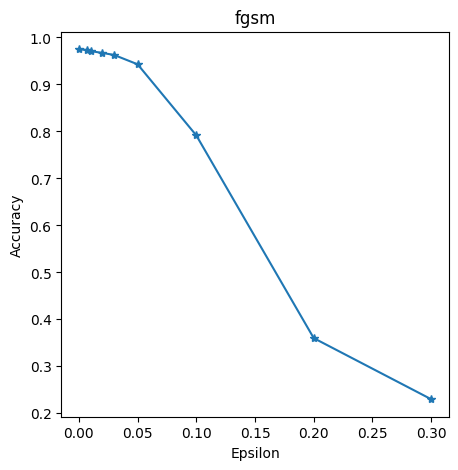

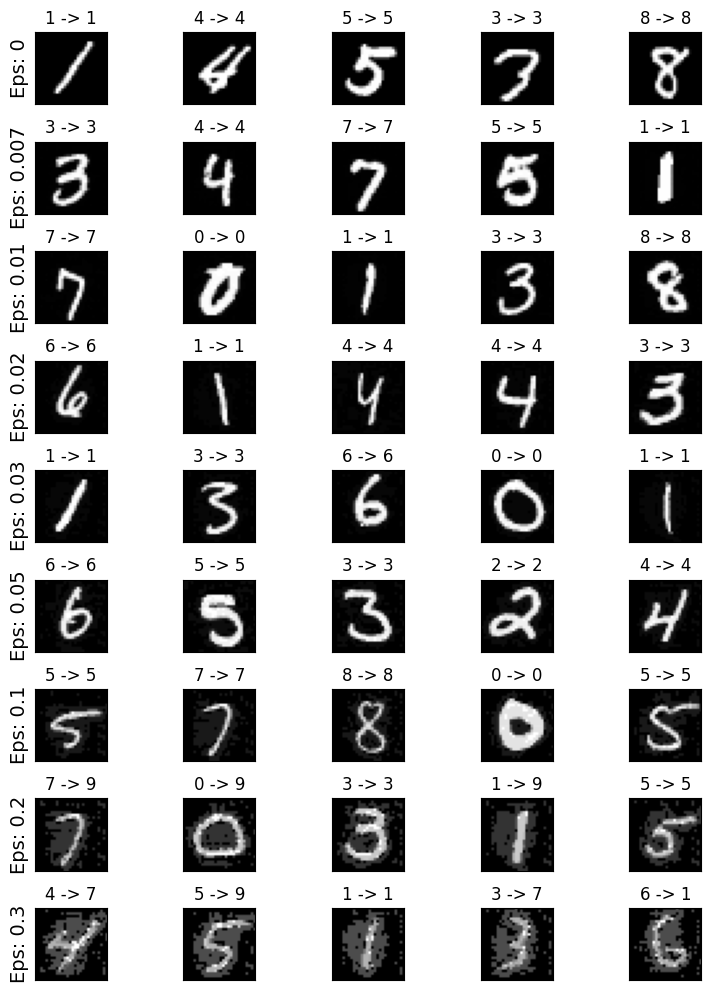

Epsilon: 0	Test Accuracy = 9758 / 10000 = 0.9758
Epsilon: 0.007	Test Accuracy = 9728 / 10000 = 0.9728
Epsilon: 0.01	Test Accuracy = 9720 / 10000 = 0.972
Epsilon: 0.02	Test Accuracy = 9691 / 10000 = 0.9691
Epsilon: 0.03	Test Accuracy = 9621 / 10000 = 0.9621
Epsilon: 0.05	Test Accuracy = 9477 / 10000 = 0.9477
Epsilon: 0.1	Test Accuracy = 8328 / 10000 = 0.8328
Epsilon: 0.2	Test Accuracy = 4140 / 10000 = 0.414
Epsilon: 0.3	Test Accuracy = 2518 / 10000 = 0.2518


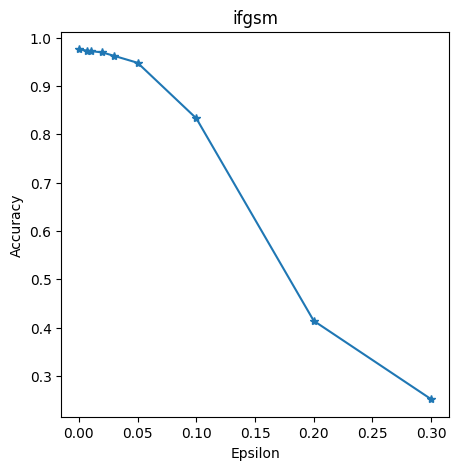

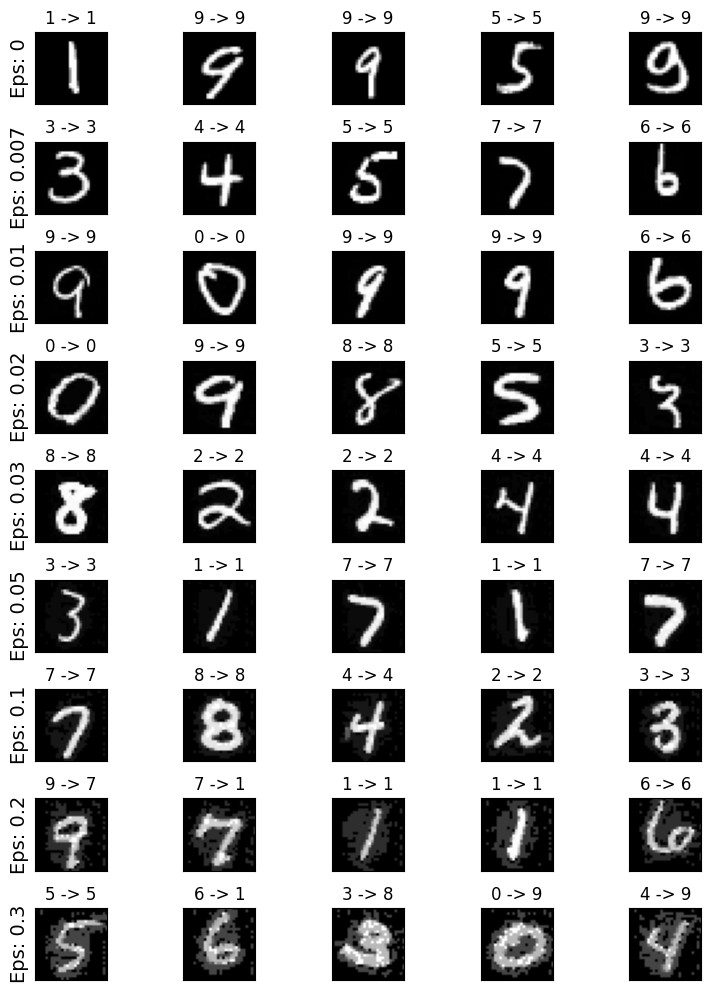

Epsilon: 0	Test Accuracy = 9746 / 10000 = 0.9746
Epsilon: 0.007	Test Accuracy = 9714 / 10000 = 0.9714
Epsilon: 0.01	Test Accuracy = 9725 / 10000 = 0.9725
Epsilon: 0.02	Test Accuracy = 9703 / 10000 = 0.9703
Epsilon: 0.03	Test Accuracy = 9633 / 10000 = 0.9633
Epsilon: 0.05	Test Accuracy = 9494 / 10000 = 0.9494
Epsilon: 0.1	Test Accuracy = 8304 / 10000 = 0.8304
Epsilon: 0.2	Test Accuracy = 4252 / 10000 = 0.4252
Epsilon: 0.3	Test Accuracy = 2493 / 10000 = 0.2493


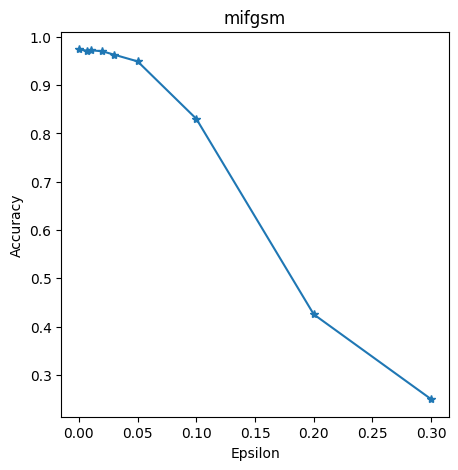

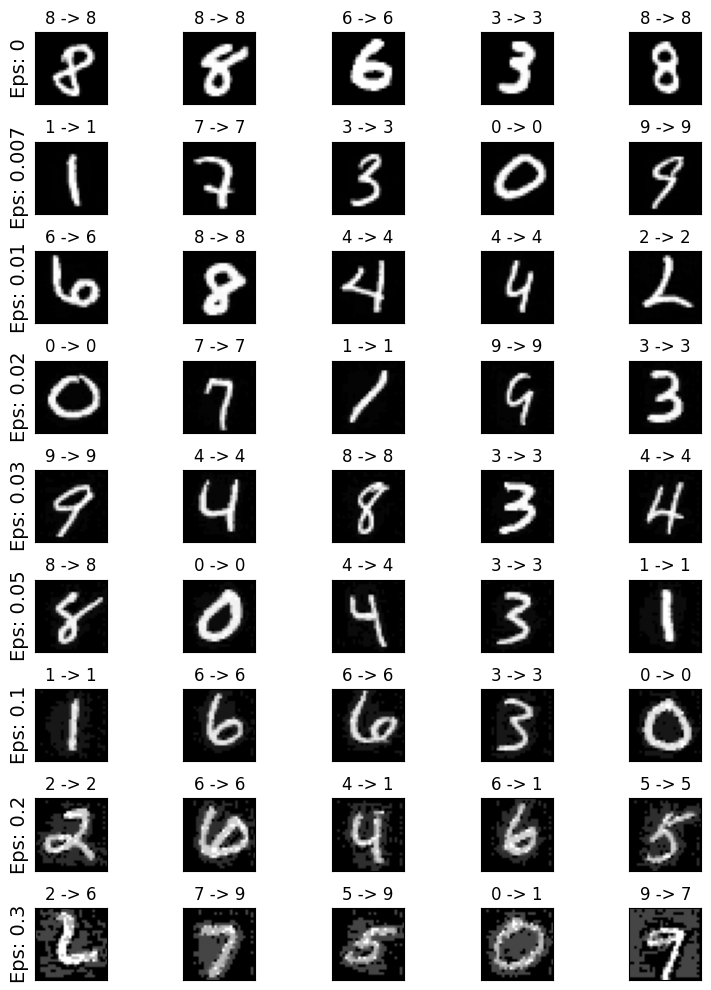

In [23]:
epsilons = [0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]
for attack in ("fgsm","ifgsm","mifgsm"):
  accuracies = []
  examples = []
  for eps in epsilons:
    acc, ex = test(model, device,test_loader,eps,attack)
    accuracies.append(acc)
    examples.append(ex)
  plt.figure(figsize=(5,5))
  plt.plot(epsilons, accuracies, "*-")
  plt.title(attack)
  plt.xlabel("Epsilon")
  plt.ylabel("Accuracy")
  plt.show()
  cnt = 0
  plt.figure(figsize=(8,10))
  for i in range(len(epsilons)):
    for j in range(len(examples[i])):
      cnt += 1
      plt.subplot(len(epsilons),len(examples[0]),cnt)
      plt.xticks([], [])
      plt.yticks([], [])
      if j == 0:
        plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
      orig,adv,ex = examples[i][j]
      plt.title("{} -> {}".format(orig, adv))
      plt.imshow(ex, cmap="gray")
  plt.tight_layout()
  plt.show()

Создадим 2 класса НС

In [24]:
class NetF(nn.Module):
  def __init__(self):
    super(NetF, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)
  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    return x

In [25]:
class NetF1(nn.Module):
  def __init__(self):
    super(NetF1, self).__init__()
    self.conv1 = nn.Conv2d(1, 16, 3, 1)
    self.conv2 = nn.Conv2d(16, 32, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(4608, 64)
    self.fc2 = nn.Linear(64, 10)
  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    return x

Переопределим функцию обучения и тестирования

In [26]:
def fit(model,device,optimizer,scheduler,criterion,train_loader,val_loader,Temp,epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  print("Fitting the model...")
  train_loss,val_loss=[],[]
  for epoch in range(epochs):
    loss_per_epoch,val_loss_per_epoch=0,0
    for phase in ('train','val'):
      for i,data in enumerate(data_loader[phase]):
        input,label = data[0].to(device),data[1].to(device)
        output = model(input)
        output = F.log_softmax(output/Temp,dim=1)
        #calculating loss on the output
        loss = criterion(output,label)
        if phase == 'train':
          optimizer.zero_grad()
          #grad calc w.r.t Loss func
          loss.backward()
          #update weights
          optimizer.step()
          loss_per_epoch+=loss.item()
      else:
        val_loss_per_epoch+=loss.item()
    scheduler.step(val_loss_per_epoch/len(val_loader))
    print("Epoch: {} Loss: {} Val_Loss: {}".format(epoch+1,loss_per_epoch/len(train_loader),val_loss_per_epoch/len(val_loader)))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))
  return train_loss,val_loss
def test(model,device,test_loader,epsilon,Temp,attack):
  correct=0
  adv_examples = []
  for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    data.requires_grad = True
    output = model(data)
    output = F.log_softmax(output/Temp,dim=1)
    init_pred = output.max(1, keepdim=True)[1]
    if init_pred.item() != target.item():
      continue
    loss = F.nll_loss(output, target)
    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data
    if attack == "fgsm":
      perturbed_data = fgsm_attack(data,epsilon,data_grad)
    elif attack == "ifgsm":
      perturbed_data = ifgsm_attack(data,epsilon,data_grad)
    elif attack == "mifgsm":
      perturbed_data = mifgsm_attack(data,epsilon,data_grad)
    output = model(perturbed_data)
    final_pred = output.max(1, keepdim=True)[1]
    if final_pred.item() == target.item():
      correct += 1
    if (epsilon == 0) and (len(adv_examples) < 5):
      adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
      adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
    else:
      if len(adv_examples) < 5:
        adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
        adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
  final_acc = correct/float(len(test_loader))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))
  return final_acc,adv_examples

Создадим функцию защиты методом дистилляции

In [27]:
def defense(device,train_loader,val_loader,test_loader,epochs,Temp,epsilons):
  modelF = NetF().to(device)
  optimizerF = optim.Adam(modelF.parameters(),lr=0.0001, betas=(0.9, 0.999))
  schedulerF = optim.lr_scheduler.ReduceLROnPlateau(optimizerF, mode='min', factor=0.1, patience=3)
  modelF1 = NetF1().to(device)
  optimizerF1 = optim.Adam(modelF1.parameters(),lr=0.0001, betas=(0.9, 0.999))
  schedulerF1 = optim.lr_scheduler.ReduceLROnPlateau(optimizerF1, mode='min', factor=0.1, patience=3)
  criterion = nn.NLLLoss()
  lossF,val_lossF=fit(modelF,device,optimizerF,schedulerF,criterion,train_loader,val_loader,Temp,epochs)
  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,epochs+1), lossF, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF,"o-",label="Val Loss")
  plt.title("Network F")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()
  #converting target labels to soft labels
  for data in train_loader:
    input, label = data[0].to(device),data[1].to(device)
    softlabel = F.log_softmax(modelF(input),dim=1)
    data[1] = softlabel
  lossF1,val_lossF1=fit(modelF1,device,optimizerF1,schedulerF1,criterion,train_loader,val_loader,Temp,epochs)
  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,epochs+1), lossF1, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF1,"o-",label="Val Loss")
  plt.title("Network F'")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()
  model = NetF1().to(device)
  model.load_state_dict(modelF1.state_dict())
  for attack in ("fgsm","ifgsm","mifgsm"):
    accuracies = []
    examples = []
    for eps in epsilons:
      acc, ex = test(model,device,test_loader,eps,1,"fgsm")
      accuracies.append(acc)
      examples.append(ex)
    plt.figure(figsize=(5,5))
    plt.plot(epsilons, accuracies, "*-")
    plt.title(attack)
    plt.xlabel("Epsilon")
    plt.ylabel("Accuracy")
    plt.show()
    cnt = 0
    plt.figure(figsize=(8,10))
    for i in range(len(epsilons)):
      for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
          plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
  plt.tight_layout()
  plt.show()


Получим результаты оценки защищенных сетей

Fitting the model...


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 1 Loss: 0.5814267195812757 Val_Loss: 4.410989210009575e-06
Epoch: 2 Loss: 0.36577064776448925 Val_Loss: 3.863632567226887e-05
Epoch: 3 Loss: 0.2601971654370091 Val_Loss: 5.724816769361496e-06
Epoch: 4 Loss: 0.19274086991808492 Val_Loss: 3.3964363974519074e-07
Epoch: 5 Loss: 0.15698915837067562 Val_Loss: 8.887248858809471e-06
Epoch: 6 Loss: 0.13177717305201264 Val_Loss: 1.942487433552742e-06
Epoch: 7 Loss: 0.11376311949268865 Val_Loss: 7.18810997568653e-09
Epoch: 8 Loss: 0.1042321673842478 Val_Loss: 4.087536409292625e-06
Epoch: 9 Loss: 0.09904471068287643 Val_Loss: 5.251660011708736e-07
Epoch: 10 Loss: 0.09408896851580188 Val_Loss: 4.748170613311231e-08


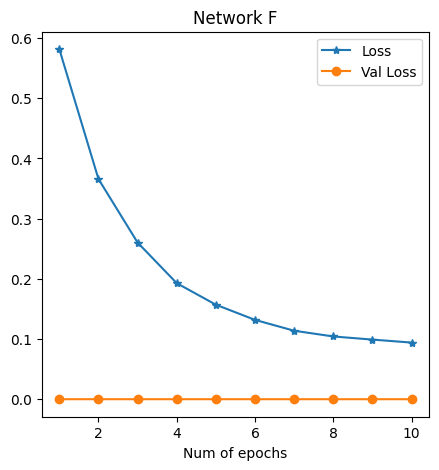

Fitting the model...
Epoch: 1 Loss: 0.7000614577058362 Val_Loss: 2.9906141944229602e-05
Epoch: 2 Loss: 0.4699710155672988 Val_Loss: 1.589178794529289e-05
Epoch: 3 Loss: 0.42023302471483626 Val_Loss: 2.137051646859618e-05
Epoch: 4 Loss: 0.38176472430142877 Val_Loss: 2.0892606780398638e-05
Epoch: 5 Loss: 0.340000021176202 Val_Loss: 9.002159512601793e-06
Epoch: 6 Loss: 0.2924935656256576 Val_Loss: 3.463808302767575e-05
Epoch: 7 Loss: 0.25902265661713536 Val_Loss: 2.11833156645298e-05
Epoch: 8 Loss: 0.22429350398874237 Val_Loss: 1.255481594853336e-07
Epoch: 9 Loss: 0.20193794088849987 Val_Loss: 2.2785429377108812e-05
Epoch: 10 Loss: 0.1837020089733083 Val_Loss: 3.469189628958702e-07


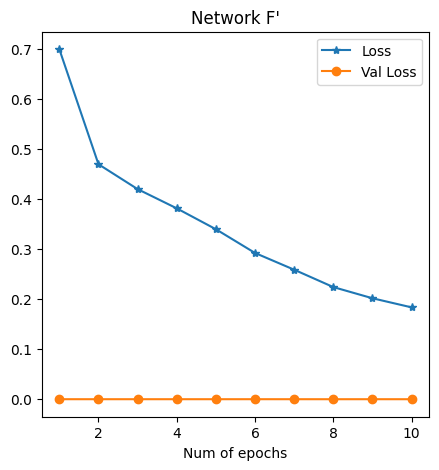

Epsilon: 0	Test Accuracy = 9254 / 10000 = 0.9254
Epsilon: 0.007	Test Accuracy = 9236 / 10000 = 0.9236
Epsilon: 0.01	Test Accuracy = 9263 / 10000 = 0.9263
Epsilon: 0.02	Test Accuracy = 9209 / 10000 = 0.9209
Epsilon: 0.03	Test Accuracy = 9212 / 10000 = 0.9212
Epsilon: 0.05	Test Accuracy = 9192 / 10000 = 0.9192
Epsilon: 0.1	Test Accuracy = 9171 / 10000 = 0.9171
Epsilon: 0.2	Test Accuracy = 9104 / 10000 = 0.9104
Epsilon: 0.3	Test Accuracy = 9081 / 10000 = 0.9081


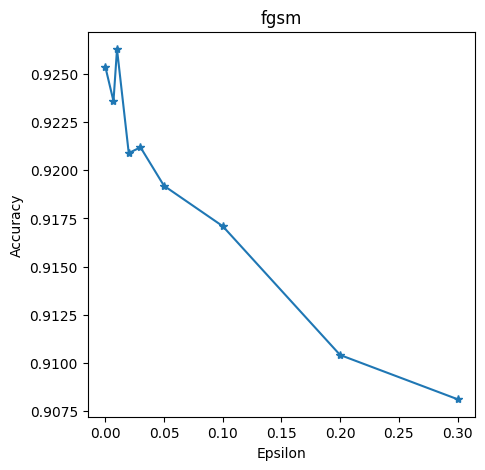

Epsilon: 0	Test Accuracy = 9252 / 10000 = 0.9252
Epsilon: 0.007	Test Accuracy = 9232 / 10000 = 0.9232
Epsilon: 0.01	Test Accuracy = 9254 / 10000 = 0.9254
Epsilon: 0.02	Test Accuracy = 9233 / 10000 = 0.9233
Epsilon: 0.03	Test Accuracy = 9231 / 10000 = 0.9231
Epsilon: 0.05	Test Accuracy = 9189 / 10000 = 0.9189
Epsilon: 0.1	Test Accuracy = 9169 / 10000 = 0.9169
Epsilon: 0.2	Test Accuracy = 9091 / 10000 = 0.9091
Epsilon: 0.3	Test Accuracy = 9082 / 10000 = 0.9082


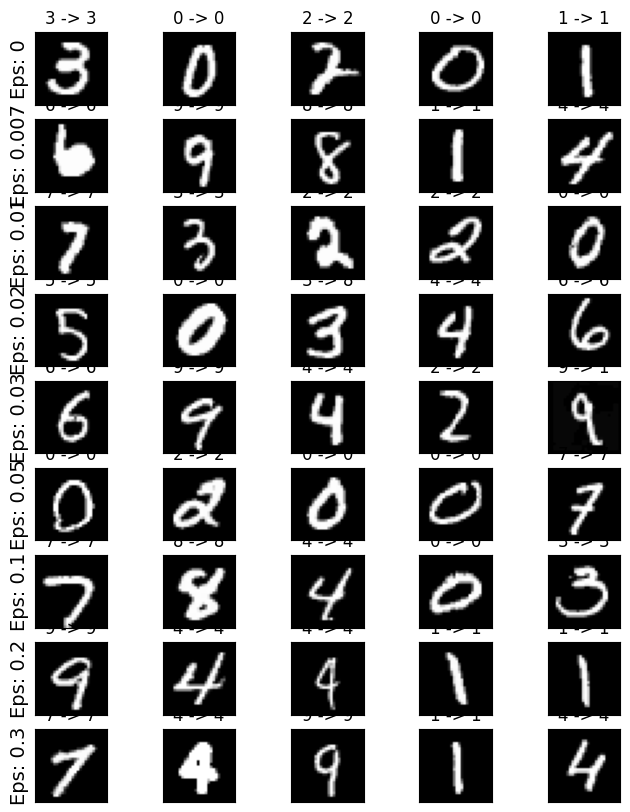

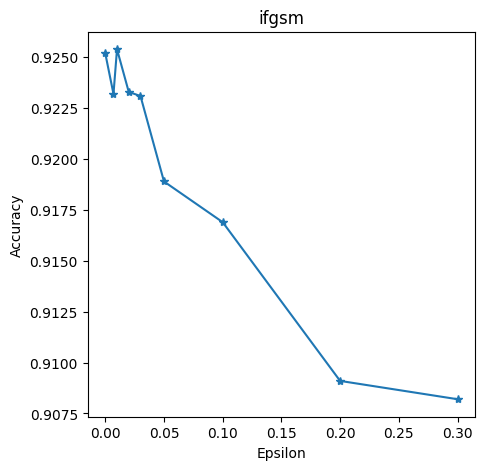

Epsilon: 0	Test Accuracy = 9251 / 10000 = 0.9251
Epsilon: 0.007	Test Accuracy = 9220 / 10000 = 0.922
Epsilon: 0.01	Test Accuracy = 9208 / 10000 = 0.9208
Epsilon: 0.02	Test Accuracy = 9214 / 10000 = 0.9214
Epsilon: 0.03	Test Accuracy = 9221 / 10000 = 0.9221
Epsilon: 0.05	Test Accuracy = 9219 / 10000 = 0.9219
Epsilon: 0.1	Test Accuracy = 9148 / 10000 = 0.9148
Epsilon: 0.2	Test Accuracy = 9095 / 10000 = 0.9095
Epsilon: 0.3	Test Accuracy = 9049 / 10000 = 0.9049


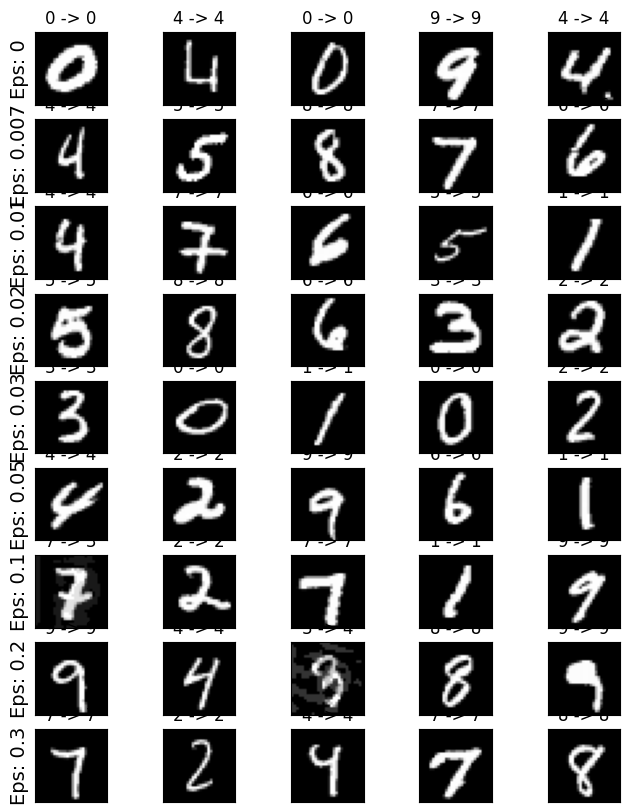

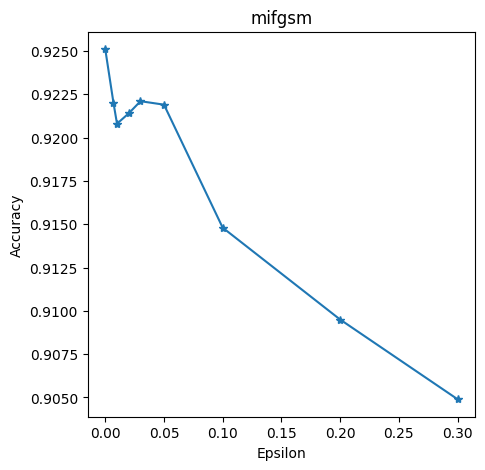

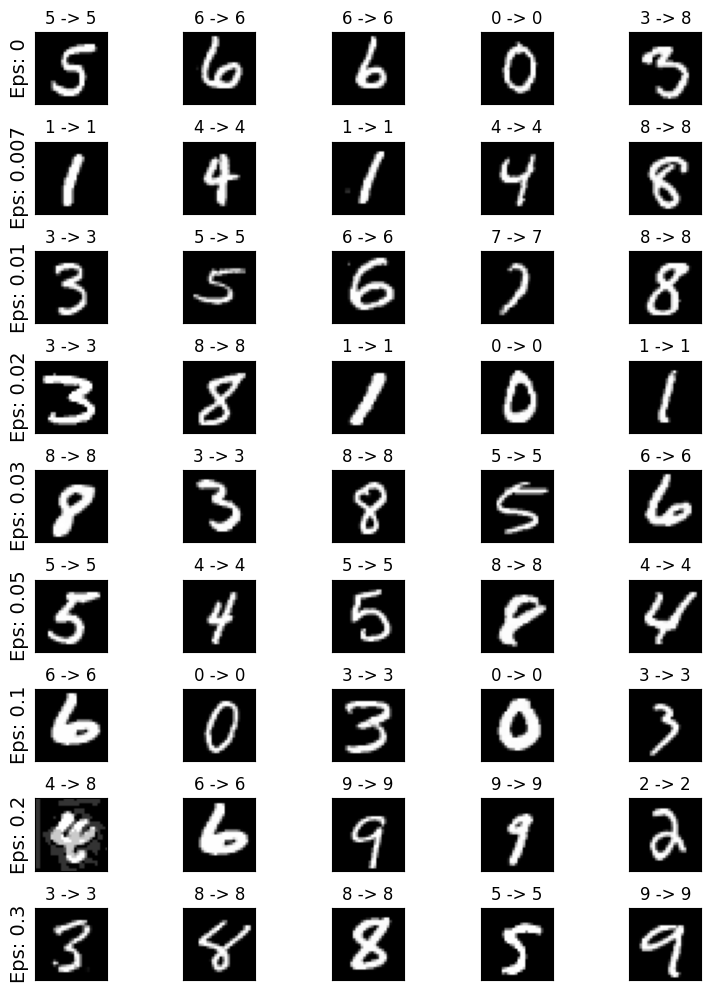

In [28]:
Temp=100
epochs=10
epsilons=[0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]
defense(device,train_loader,val_loader,test_loader,epochs,Temp,epsilons)